### Most of the functions used in this notebook have been rewritten and documented in my_hmf_cmf_lib.py

Using CAMB for Powers spectra
In this notebook, 
- compute and display the Power Spectrum prediction from CAMB

CAMB is described here: https://camb.readthedocs.io and is a requirement for the comparison. This notebook uses the CosmoUtils library, also available on the wiki.


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower

In [116]:
plt.style.use('stylesheet.mplstyle')

## Halo Mass Function (HMF)

Predicting the number density n(M) of halos with mass between M and M +dM

### Constants

In [117]:
H0=67.00 # km/s/Mpc
h=H0/100. # reduced hubble parameter
TCMB=2.7255 # CMB temperature
s8=0.8344 # sigma 8
ns=0.96 # slope of primordial power spectrum
As = 2e-9

# ob=0.002 # low to mimick dark matter only simulation
ob=0.049 # lambdaCDM parameter

om=0.3175
ov=1.0-om 
omk=0.0
z=0.0

In [118]:
maxkh=1e3
minkh=1e-4

In [119]:
pars = camb.set_params(H0=H0, TCMB=TCMB, ombh2=ob*h**2, omch2=(om-ob)*h**2, ns=ns, As=As, omk=omk, )
pars.set_matter_power(redshifts=[0., z+1e-6], kmax=maxkh)

results = camb.get_results(pars)
s8_fid = results.get_sigma8_0()

Note: redshifts have been re-sorted (earliest first)


In [120]:
G=6.67e-11 #m^3 kg^−1 s^−2
M_sun = 1.989e30  # kg
Mpc_to_m = 3.086e22  # meters
delta_c = 1.68647 # critical overdensity (Sheth, Tormen, 2002)

In [121]:
rho_0 = om * 3 * (H0*1e3/Mpc_to_m)**2 / 8 / np.pi / G # mean density in kg/m^-3
rho_0_Msun_Mpc3 = rho_0/(M_sun)*(Mpc_to_m)**3 # mean density in Msun/Mpc^3 
rho_0_h2_Msun_Mpc3 = rho_0/(M_sun/h)*(Mpc_to_m/h)**3 # mean density in h^2*Msun/Mpc^3 

print(f'rho_0 = {rho_0:.2e} kg/m^-3 and should be of the order of 10^-27 kg/m^-3 (nasa)')
print(f'rho_0 = {rho_0_Msun_Mpc3:.2e} Msun/Mpc^3')

rho_0 = 2.68e-27 kg/m^-3 and should be of the order of 10^-27 kg/m^-3 (nasa)
rho_0 = 3.96e+10 Msun/Mpc^3


In [122]:
M_hmf_min=8 # Msun/h
M_hmf_max=16 # Msun/h

In [123]:
from hmf import MassFunction
from hmf.density_field.transfer_models import CAMB

# mf with CAMB transfer model
mf_PS = MassFunction(transfer_model=CAMB, transfer_params={"camb_params": pars},Mmin=M_hmf_min, Mmax=M_hmf_max, n=ns, sigma_8=s8, z=z, delta_c=delta_c, cosmo_params={"H0":H0, "Om0":om, "Ob0":ob,"Tcmb0":TCMB},hmf_model="PS")
mf_ST = MassFunction(transfer_model=CAMB, transfer_params={"camb_params": pars},Mmin=M_hmf_min, Mmax=M_hmf_max, n=ns, sigma_8=s8, z=z, delta_c=delta_c, cosmo_params={"H0":H0, "Om0":om, "Ob0":ob,"Tcmb0":TCMB},hmf_model="ST")

/home/mesquita/.local/lib/python3.10/site-packages/hmf/density_field/transfer_models.py:233: UserWarning: 'extrapolate_with_eh' was not set. Defaulting to True, which is different behaviour than versions <=3.4.4. This warning may be removed in v4.0. Silence it by setting extrapolate_with_eh explicitly.
  warnings.warn(


In [124]:
array_length = len(mf_PS.m)
print(array_length)

M_list = np.linspace(M_hmf_min,M_hmf_max,array_length) 
M_list = 10**M_list #M in M_sun/h

z_range = [9, 10.5, 12, 14.5]
# z_range=[0,1,2,3,5,7,9]

800


### Makng the functions

We first make a function to get pk and kh depending on z

In [125]:
def compute_matter_power_spectrum(z, pars=pars, ns=ns, s8=s8, s8_fid=s8_fid, minkh=minkh, maxkh=maxkh, npoints=500):
    """
    Compute the matter power spectrum using CAMB
    
    Inputs :
    z : Redshift 
    pars : CAMB parameters object
    s8_fid : Fiducial sigma8 value
    ns : Spectral index of primordial power spectrum
    s8 : Current sigma8 value
    minkh : Minimum k/h value for the power spectrum
    maxkh : Maximum k/h value for the power spectrum
    npoints : Number of points in the power spectrum
    
    Outputs :
    kh : Array of k/h values in h/Mpc
    zcamb : Redshift at which the power spectrum is computed (should be close to z)
    pk : Array of power spectrum values in (Mpc/h)^3
    """
    
    As_corr = As*s8**2/s8_fid**2
    pars.InitPower.set_params(As=As_corr, ns=ns)
    pars.set_matter_power(redshifts=[0., z+1e-6], kmax=maxkh)
    
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, zcamb, pk = results.get_matter_power_spectrum(minkh=minkh, maxkh=maxkh, npoints=npoints)
    
    return kh, zcamb, pk

Redefining sig_camb as a function to be able to take its derivative

In [126]:
from scipy.differentiate import derivative
import scipy.integrate as integ

def compute_sig_camb(R, kh, pk):
    '''
    Compute the variance of the density field at scale R using CAMB power spectrum
    
    Inputs :
    R : radius of the region in Mpc/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    
    Outputs :
    sig_camb is unitless
    '''
    x = kh * R
    w = 3 * (np.sin(x) - x * np.cos(x)) / x**3
    pconv = pk[-1, :] / (2 * np.pi)**3
    sig_camb = np.sqrt(integ.trapezoid((pconv) * 4 * np.pi * kh**2 * w**2, kh))
    return sig_camb

def derivative_of_sig_camb(R, kh, pk, h=1e-5):
    '''
    Computes the derivative of the variance of the density field at scale R using finite differences
    
    Inputs :
    R : radius of the region in Mpc/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    h is the step size for finite difference
    
    Outputs :
    dsig_dR : Derivative of the variance with respect to R
    '''
    sig_plus = compute_sig_camb(R + h, kh, pk)
    sig_minus = compute_sig_camb(R - h, kh, pk)
    dsig_dR = (sig_plus - sig_minus) / (2 * h)
    return dsig_dR

In [127]:
def M_to_R(M):
    '''
    Converts mass to radius using the mean density of the Universe (always assumed to be true) for a spherical collapse
    
    M in M_sun/h
    R in Mpc/h
    '''
    return (3 * M / (4 * np.pi * rho_0_h2_Msun_Mpc3))**(1/3)

def R_to_M(R):
    '''
    Converts radius to mass using the mean density of the Universe (always assumed to be true) for a spherical collapse
    
    R in Mpc/h
    M in M_sun/h
    '''
    return 4 / 3 * np.pi * rho_0_h2_Msun_Mpc3 * R**3 

def dR_dM_fct(M):
    '''
    Computes the derivative of radius with respect to mass for a spherical collapse
    
    M in M_sun/h
    R in Mpc/h
    '''
    return (3/(4*np.pi*rho_0_h2_Msun_Mpc3))**(1/3) * M**(-2/3) / 3
    

### Starting with the Press-Schechter (PS) HMF

Let's try to compute $n_{PS}$ :

$\displaystyle n_{PS}(M)=\sqrt{\frac{2}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\frac{\delta_c}{\sigma(M,z)^2}\exp(-\frac{\delta_c^2}{2\sigma(M,z)^2})$

with :

$\displaystyle \frac{d\sigma}{dM}=\frac{d\sigma}{dR}\frac{dR}{dM}=\frac{d\sigma}{dR}\cdot\frac{1}{3}(\frac{3}{4\pi\rho_0})^{\frac{1}{3}}M^{-\frac{2}{3}}$

In [128]:
def compute_n_PS(M, kh, pk):
    '''
    Computes the Press-Schechter mass function
    
    Inputs :
    M : Mass of the region in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    
    Outputs :
    n_PS : Press-Schechter mass function value at mass M in h^4/Msun/Mpc^-3
    
    '''
    R = M_to_R(M)
    sig_camb = compute_sig_camb(R, kh, pk)

    #dsig/dM = dsig/dR * dR/dM
    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    dR_dM =  dR_dM_fct(M)
    dsig_dM = dsig_dR * dR_dM
    
    n_PS = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_h2_Msun_Mpc3 / M) * (delta_c / sig_camb**2) * np.exp(-delta_c**2 / 2 / sig_camb**2)
    return n_PS

### Let's now implement the Sheth and Tormen (ST) HMF

It is given by :

$\displaystyle n_{ST}(M)=A\sqrt{\frac{2a}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\left[ 1+\left( \frac{\sigma(M,z)^2}{a\delta_c^2} \right)^{0.3} \right]\frac{\delta_c}{\sigma(M,z)^2}\exp(-\frac{a\delta_c^2}{2\sigma(M,z)^2})$

with :

$a=0.707$ and $A=0.3222$.

In [129]:
def compute_n_ST(M,kh,pk):
    '''
    Computes the Sheth-Tormen mass function
    
    Inputs :
    M : Mass of the region in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    
    Outputs :
    n_ST : Sheth-Tormen mass function value at mass M in h^4/Msun/Mpc^-3
    '''
    a=0.707
    A=0.3222
    
    R = M_to_R(M)
    
    sig_camb = compute_sig_camb(R, kh, pk)
    
    #dsig/dM = dsig/dR * dR/dM
    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    dR_dM =  dR_dM_fct(M)
    dsig_dM = dsig_dR * dR_dM    
    
    n_ST = A * np.sqrt(2*a/np.pi) * np.abs(dsig_dM) * (rho_0_h2_Msun_Mpc3 / M) * (1+(sig_camb**2/a/delta_c**2)**0.3) * (delta_c / sig_camb**2) * np.exp(-a*delta_c**2 / 2 / sig_camb**2)
    return n_ST

### General function to cumpute the HMF

In [130]:
def hmfcalc(M,kh,pk,model):
    '''
    Computes the HMF depending on the chosen model
    
    Inputs :
    M : Mass of the region in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    model : "PS" for Press-Schechter or "ST" for Sheth-Tormen
    
    Outputs :
    hmf : HMF value at mass M in h^4/Msun/Mpc^-3
    '''
    if model == "PS" :
        hmf = compute_n_PS(M, kh, pk)
    elif model == "ST":
        hmf = compute_n_ST(M, kh, pk)
    else :
        print("Model not recognized")
        hmf = None
    return hmf

### Computing the kh and pk for the z_range we set earlier

We are trying here to reproduce the Fig 1. from Meriot & Semelin (2024)

In [131]:
kh_results, pk_results = [], []
n_PS_results, n_ST_results = [], []

for idx, z in enumerate(z_range):
    #compute the power spectrum for a given redshift
    kh, _, pk = compute_matter_power_spectrum(z)
    #and store it for later use
    kh_results.append(kh)
    pk_results.append(pk)
    
    n_PS_list = [hmfcalc(M_list[i], kh_results[idx], pk_results[idx], "PS") for i in range(array_length)]
    n_PS_results.append(n_PS_list)
    
    n_ST_list = [hmfcalc(M_list[i], kh_results[idx],  pk_results[idx], "ST") for i in range(array_length)]
    n_ST_results.append(n_ST_list)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


/tmp/ipykernel_2077572/1968252715.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


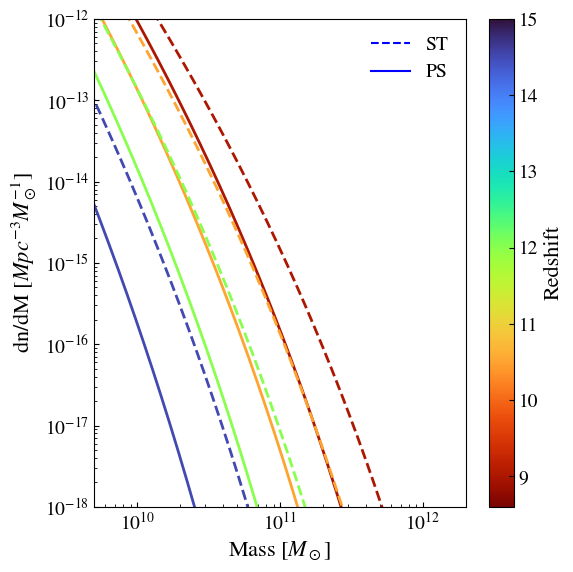

In [132]:
import matplotlib.cm as cm

plt.figure(figsize=(6, 6))

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15)
colors = cmap(norm(z_range))

for idx, z in enumerate(z_range):
    mf_PS.update(z=z)
    mf_ST.update(z=z)
    #reuse the previously done computation stored in kh_results and pk_results
    plt.loglog(M_list*h, np.array(n_ST_results[idx])/h**4, '--', color=colors[idx], lw=2)
    plt.loglog(M_list*h, np.array(n_PS_results[idx])/h**4, '-', color=colors[idx], lw=2)
    # plt.loglog(mf_PS.m*h, mf_ST.dndm/h**4, linestyle="dotted", color=colors[idx], lw=2)
    # plt.loglog(mf_ST.m*h, mf_ST.dndm/h**4, linestyle="dotted", color=colors[idx], lw=2)
    
# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Redshift')

# plt.title(f"HMF my computations")
plt.loglog([], [], '--', label='ST', color='blue')
plt.loglog([], [], '-', label='PS', color='blue')
# plt.loglog([], [],linestyle="dotted", label="HMFlib", color="blue")

plt.ylim([1e-18, 1e-12])
plt.xlim([5e9, 2e12])
plt.xlabel('Mass [$M_\odot$]')
plt.ylabel('dn/dM $[Mpc^{-3}M_\odot^{-1}]$')
plt.tight_layout()
plt.legend()
plt.savefig('./saved_results/misc/my_hmf_reprod_meriot_with_lib.svg', dpi=300, bbox_inches='tight')
plt.show()

This shows the HMF curve for a Universe at different redshifts.

On the general shape of the HMF, there are much more halos of small mass than higher mass because smaller halos form first and later merge to build larger halos (Lacey et al. 1993). 

Moreover, we can see that, a higher redshift (younger Universe) means a lower halo number density, this shows the progressive formation of cosmic structures over time. 

In the early Universe, density fluctuations had less time to grow under gravity which translates in a lower abundance of collapsed halos, especially for higher mass halos (Davis et al. 1985).

### Adding the hmf library to compare the results

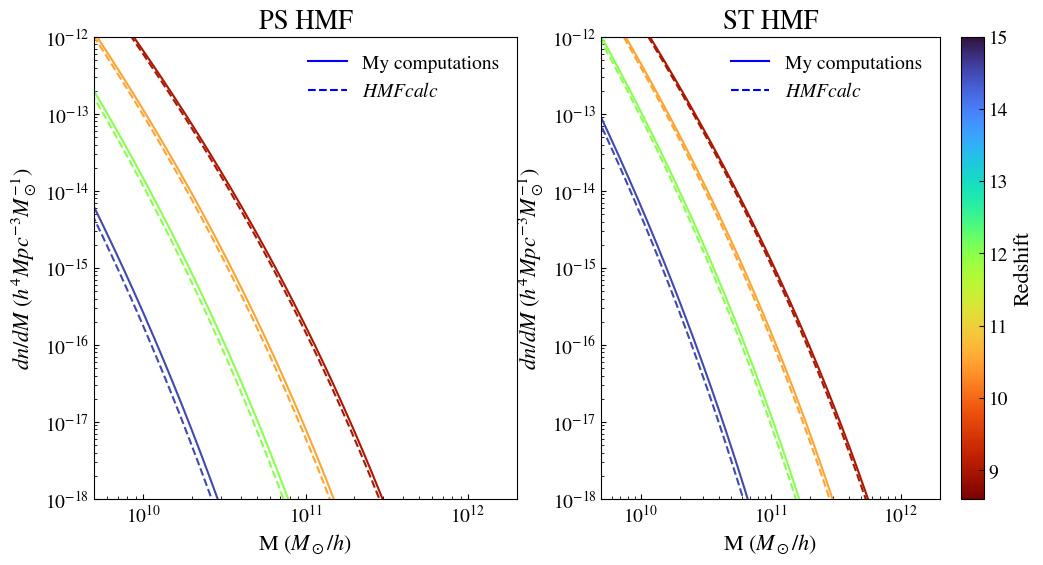

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15)
colors = cmap(norm(z_range))

for idx, z in enumerate(z_range):
    mf_PS.update(z=z)
    ax1.loglog(M_list, np.array(n_PS_results[idx]), '-', color=colors[idx])
    ax1.loglog(mf_PS.m, mf_PS.dndm, '--', color=colors[idx])

ax1.loglog([], [], '-', label='My computations', color='blue')
ax1.loglog([], [], '--', label='$HMFcalc$', color='blue')
ax1.set_title("PS HMF")
ax1.set_ylim([1e-18, 1e-12])
ax1.set_xlim([5e9, 2e12])
# ax1.set_ylim([1e-20, 1e-7])
# ax1.set_xlim([5e7, 2e12])

ax1.set_xlabel(r'M ($M_\odot/h$)')
ax1.set_ylabel(r'$dn/dM \ (h^4Mpc^{-3}M_\odot^{-1})$')
ax1.legend()

for idx, z in enumerate(z_range):
    mf_ST.update(z=z)
    ax2.loglog(M_list, np.array(n_ST_results[idx]), '-', color=colors[idx])
    ax2.loglog(mf_ST.m, mf_ST.dndm, '--', color=colors[idx])

# colorbar for the second subplot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2)
cbar.set_label('Redshift')

ax2.loglog([], [], '-', label='My computations', color='blue')
ax2.loglog([], [], '--', label='$HMFcalc$', color='blue')
ax2.set_title("ST HMF")
ax2.set_ylim([1e-18, 1e-12])
ax2.set_xlim([5e9, 2e12])
# ax2.set_ylim([1e-20, 1e-7])
# ax2.set_xlim([5e7, 2e12])

ax2.set_xlabel(r'M ($M_\odot/h$)')
ax2.set_ylabel(r'$dn/dM \ (h^4Mpc^{-3}M_\odot^{-1})$')
ax2.legend()

plt.show()

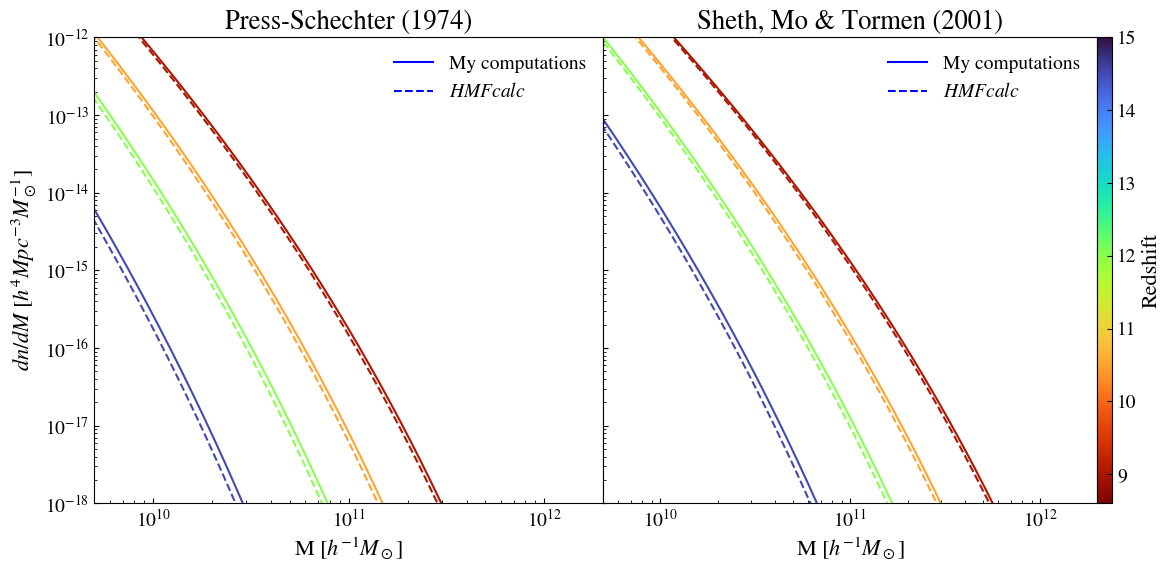

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True, gridspec_kw={'wspace': 0.0})


for idx, z in enumerate(z_range):
    mf_PS.update(z=z)

cmap = cm.turbo_r
norm = plt.Normalize(vmin=8.6, vmax=15)
colors = cmap(norm(z_range))

for idx, z in enumerate(z_range):
    mf_PS.update(z=z)
    ax1.loglog(M_list, np.array(n_PS_results[idx]), '-', color=colors[idx])
    ax1.loglog(mf_PS.m, mf_PS.dndm, '--', color=colors[idx])

ax1.loglog([], [], '-', label='My computations', color='blue')
ax1.loglog([], [], '--', label='$HMFcalc$', color='blue')
ax1.set_title("Press-Schechter (1974)")
ax1.set_ylim([1e-18, 1e-12])
ax1.set_xlim([5e9, 2e12])
ax1.set_xlabel(r'M [$h^{-1}M_\odot$]')
ax1.set_ylabel(r'$dn/dM \ [h^4Mpc^{-3}M_\odot^{-1}]$')
ax1.legend()

for idx, z in enumerate(z_range):
    mf_ST.update(z=z)
    ax2.loglog(M_list, np.array(n_ST_results[idx]), '-', color=colors[idx])
    ax2.loglog(mf_ST.m, mf_ST.dndm, '--', color=colors[idx])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.0)  

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Redshift')

ax2.loglog([], [], '-', label='My computations', color='blue')
ax2.loglog([], [], '--', label='$HMFcalc$', color='blue')
ax2.set_title("Sheth, Mo & Tormen (2001)")
ax2.set_ylim([1e-18, 1e-12])
ax2.set_xlim([5e9, 2e12])
ax2.set_xlabel(r'M [$h^{-1}M_\odot$]')
# ax2.set_ylabel(r'$dn/dM \ [h^4Mpc^{-3}M_\odot^{-1}]$')
ax2.legend()
plt.tight_layout()
plt.savefig('./saved_results/misc/hmfcalc_vs_mine.svg', dpi=300, bbox_inches='tight')
plt.show()


We can see that my results are very close to the results obtained via HMFcalc. The small deviation may come from the fact that default parameters for the cosmology.

### Trying to reproduce Fig 2 of A. Jenkins et al. (2000)

We want to compute $dn/d\log_{10}M$ :
and we know how to compute dn/dM, we simply have :

$\displaystyle \frac{dn}{d\log_{10}M} = \frac{dn}{dM} \times \frac{dM}{d\log_{10}M}$

Since

$\displaystyle d\log_{10}M = \frac{dM}{M \ln(10)}$

we obtain

$\displaystyle \frac{dM}{d\log_{10}M} = M \ln(10)$

Thus:

$\displaystyle \frac{dn}{d\log_{10}M} = \frac{dn}{dM} \times M \ln(10)$



Note: redshifts have been re-sorted (earliest first)
z=0.0, sigma8=0.8316149929874254


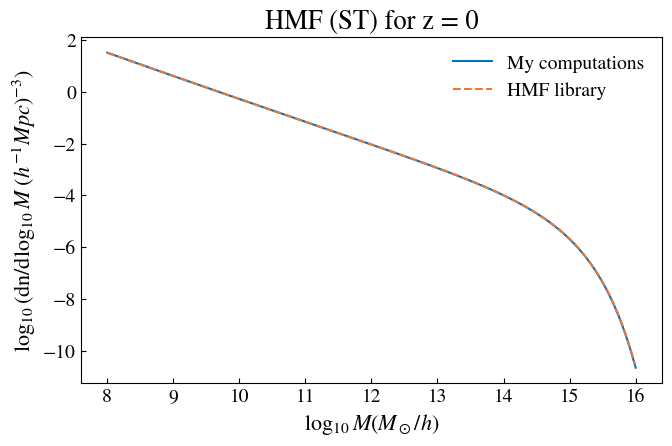

In [135]:
z0=0.0

mf_ST.update(z=z0)

M0_list = np.linspace(M_hmf_min,M_hmf_max,array_length) #M in M_sun/h
M0_list = 10**M0_list
R0_list = (3*M0_list/(4*np.pi*rho_0_h2_Msun_Mpc3))**(1/3) # in Mpc/h

kh0,zcamb,pk0=compute_matter_power_spectrum(z0)
dn_dlog10M_list = [hmfcalc(M0_list[i], kh0, pk0,"ST")*M0_list[i]*np.log(10) for i in range(array_length)]

print(f"z={z0}, sigma8={compute_sig_camb(8, kh0,pk0)}")

plt.plot(np.log10(M0_list), np.log10(dn_dlog10M_list),'-', label="My computations")
plt.plot(np.log10(mf_ST.m),np.log10(mf_ST.dndlog10m), '--', label="HMF library") #same thing as line above

plt.title(f"HMF (ST) for z = 0")
# plt.ylim([-8.5, -1.25])
# plt.xlim([11, 15.8])
plt.xlabel('$\log_{10}M (M_\odot/h$)')
plt.ylabel('$\log_{10}($dn/d$\log_{10}M \ (h^{-1}Mpc)^{-3})$')
plt.legend()
plt.show()

OK

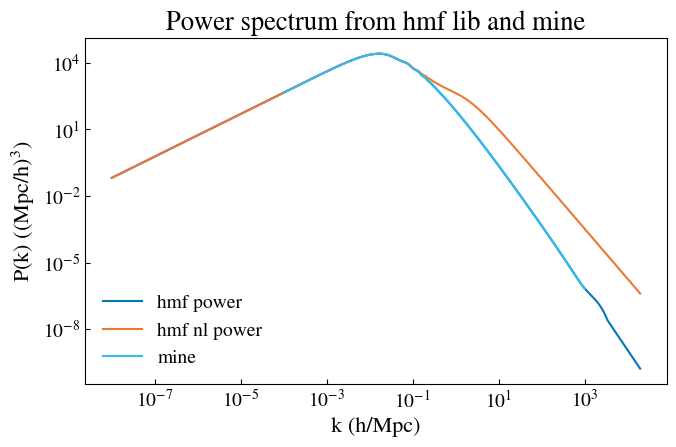

In [136]:
plt.figure()

mf_ST.update(z=0)
plt.loglog(mf_ST.k,mf_ST.power, label = "hmf power")
plt.loglog(mf_ST.k,mf_ST.nonlinear_power,label = "hmf nl power")
plt.loglog(kh0,pk0[-1,:], label = "mine")
plt.xlabel('k (h/Mpc)')
plt.ylabel(r'P(k) ((Mpc/h)$^3$)')
plt.title('Power spectrum from hmf lib and mine')
plt.legend()
plt.show()

Computing the power spectrum right before CMF section of the notebook even though it is to compute it just so I don't have to recompute it when computing the cmf section

In [137]:
z_hirrah21 =9.48

kh_hirrah21, _, pk_hirrah21 = compute_matter_power_spectrum(z_hirrah21)

Note: redshifts have been re-sorted (earliest first)


## Conditional Mass Function (CMF)

### Constants

In [ ]:
R0_mpc = 5 # arbitrary (Mpc)
R0 = R0_mpc*h #Mpc/h

Mregion = R_to_M(R0) #M_sun/h
Vregion = 4/3*np.pi*R0**3 # (Mpc/h)^3

Mmin = 1e9*h #Msun/h

print(f"{Mregion:.2e}")

1.39e+13


In [139]:
M_list2 = np.linspace(np.log10(Mmin),np.log10(Mregion), 500)
M_list2 = 10**M_list2[:-1] #Msun/h

delta_range = np.array([-0.4, -0.2, 0.0, 0.2, 0.4])

### Functions

$\displaystyle n_{EPS}(M)=\sqrt{\frac{2}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\frac{\sigma(\delta_c-\delta_0)}{(\sigma^2-\sigma_0^2)^{3/2}}\exp(-\frac{\delta_c^2}{2(\sigma^2-\sigma_0^2)})$


In [140]:
def n_EPS(M, kh, pk, R0, delta_0):
    '''
    M in Msun/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    R0 in Mpc/h
    delta_0 in unitless
    '''
    R = M_to_R(M)
    
    sig_camb = compute_sig_camb(R, kh, pk)
    sig_camb_0 = compute_sig_camb(R0, kh, pk)
    
    delta_sig = sig_camb**2-sig_camb_0**2

    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    # dR_dM =  (3/4/np.pi/rho_0_h2_Msun_Mpc3)**(1/3) * M**(-2/3) / 3
    dR_dM = dR_dM_fct(M)
    dsig_dM = dsig_dR * dR_dM
    
    # breaking terms down to find my error
    first_term = np.sqrt(2/np.pi) * np.abs(dsig_dM) #h/Msun
    second_term = rho_0_h2_Msun_Mpc3 / M #h3 / Mpc3
    third_term = sig_camb * (delta_c-delta_0) / (delta_sig)**(3/2) #unitless
    exp_argument = -(delta_c-delta_0)**2 / 2 / delta_sig #unitless
    fourth_term = np.exp(exp_argument)
    
    n_EPS_val = first_term * second_term * third_term * fourth_term
    # n_EPS_val = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_h2_Msun_Mpc3 / M) * (sig_camb*(delta_c-delta_0) /(sig_camb**2-sig_camb_0**2)**(3/2)) * np.exp(-delta_c**2 / 2 / (sig_camb**2-sig_camb_0**2))
    return n_EPS_val


def n_EPS_scaled(M, kh, pk, R0, delta_0):
    '''
    M in Msun/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    R0 in Mpc/h
    delta_0 in unitless
    '''
    R = M_to_R(M)
    
    sig_camb = compute_sig_camb(R, kh, pk) 
    sig_camb_0 = compute_sig_camb(R0, kh, pk)
    
    ###
    ### fig 2. Meriot & Semelin (2024) : "the σ in the EPS model has been scaled up by 5% on average."
    sig_camb = sig_camb*1.05
    ###
    
    delta_sig = sig_camb**2-sig_camb_0**2
    
    dsig_dR = derivative_of_sig_camb(R, kh, pk) #h/Mpc
    # dR_dM =  (3/4/np.pi/rho_0_h2_Msun_Mpc3)**(1/3) * M**(-2/3) / 3
    dR_dM = dR_dM_fct(M) # Mpc/Msun
    dsig_dM = dsig_dR * dR_dM #h / Msun
    
    # breaking terms down to find my error
    first_term = np.sqrt(2/np.pi) * np.abs(dsig_dM) #h/Msun
    second_term = rho_0_h2_Msun_Mpc3 / M #h3 / Mpc3
    third_term = sig_camb * (delta_c-delta_0) / (delta_sig)**(3/2) #unitless
    exp_argument = -(delta_c-delta_0)**2 / 2 / delta_sig #unitless
    fourth_term = np.exp(exp_argument)
    
    n_EPS_val = first_term * second_term * third_term * fourth_term
    # n_EPS_val = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_h2_Msun_Mpc3 / M) * (sig_camb*(delta_c-delta_0) /(sig_camb**2-sig_camb_0**2)**(3/2)) * np.exp(-delta_c**2 / 2 / (sig_camb**2-sig_camb_0**2))
    return n_EPS_val

$\displaystyle n_{c,ST}(M)=\sqrt{\frac{2}{\pi}}\left| \frac{d\sigma}{dM} \right|\frac{\rho_0}{M}\frac{\left|T(\sigma^2|\sigma_0^2)\right|\sigma}{(\sigma^2-\sigma_0^2)^{3/2}}\exp\left(-\frac{(B(\sigma^2,z)-\delta_0)^2}{2(\sigma^2-\sigma_0^2)}\right)$

with :

$\displaystyle a=0.707$

$\displaystyle T(\sigma^2|\sigma_0^2) = \sum_{n=0}^{5}\frac{(\sigma_0^2-\sigma^2)^n}{n!}\frac{\partial^n (B(\sigma^2,z)-\delta_0))}{\partial (\sigma^2)^n}$

$\displaystyle B(\sigma^2,z)=\sqrt{a}\delta_c(1+\beta(a\frac{\delta_c^2}{\sigma^2})^{-\alpha})$

$\displaystyle\frac{\partial^n B}{\partial y^n} = \beta(a\delta_c^2)^{-\alpha+1/2}\frac{\alpha!}{(\alpha-n)!}y^{\alpha-n}$ for $n \geq 1$ and $y=\sigma^2$.

and : 

$\alpha = 0.615\ \text{and} \ \beta=0.485$.

In [141]:
from scipy.special import factorial

# B function
def B_func(sig2):
    '''
    Mass dependant threshold function
    input is SQUARED
    '''
    a=0.707
    alpha=0.615
    beta=0.485
    res = np.sqrt(a)*delta_c*(1+beta*(a*delta_c**2/sig2)**(-alpha))
    return res

def B_nth_derivative(sig2, n):
    '''
    $\frac{\partial^n B}{\partial y^n} = \beta(a\delta_c^2)^{-\alpha+1/2}\frac{\alpha!}{(\alpha-n)!}y^{\alpha-n}$
    '''
    a=0.707
    alpha=0.615
    beta=0.485
    if n==0:
        return B_func(sig2)
    res = beta*(a*delta_c**2)**(-alpha+0.5) * factorial(alpha)/factorial(alpha - n, extend='complex') * (sig2)**(alpha-n) #extend = 'complex' to be able to put negative values inside the factorial function
    return res

In [142]:
def T_func(sig, sig0, delta_0, order_of_taylor_series=5):
    res = 0
    delta_sig = sig**2 - sig0**2
    for n in range(order_of_taylor_series+1):
        if n == 0:
            der = B_func(sig**2)-delta_0
        else :
            der = B_nth_derivative(sig**2,n)
        res += (-delta_sig)**n * der / factorial(n) 
    return res

def n_cST(M, kh, pk, R0, delta_0):
    '''
    M in Msun/h
    kh in h/Mpc
    pk in (Mpc/h)^3
    R0 in Mpc/h
    delta_0 in unitless
    '''
    R = M_to_R(M)
    
    sig_camb = compute_sig_camb(R, kh, pk)
    sig_camb_0 = compute_sig_camb(R0, kh, pk)
    delta_sig = sig_camb**2 - sig_camb_0**2
    
    dsig_dR = derivative_of_sig_camb(R, kh, pk)
    # dR_dM =  (3/4/np.pi/rho_0_h2_Msun_Mpc3)**(1/3) * M**(-2/3) / 3
    dR_dM = dR_dM_fct(M)
    dsig_dM = dsig_dR * dR_dM
    
    T_res = T_func(sig_camb, sig_camb_0, delta_0)
    B_res = B_func(sig_camb**2)
    
    # breaking terms down to find an error
    first_term = np.sqrt(2/np.pi) * np.abs(dsig_dM)
    second_term = rho_0_h2_Msun_Mpc3 / M
    third_term = np.abs(T_res)
    fourth_term = sig_camb/delta_sig**(3/2)
    
    exp_argument = -(B_res-delta_0)**2 / 2 / delta_sig  
    fifth_term = np.exp(exp_argument)
    
    n_cST_val = first_term * second_term * third_term * fourth_term * fifth_term
    # n_cST_val = np.sqrt(2/np.pi) * np.abs(dsig_dM) * (rho_0_h2_Msun_Mpc3 / M) * np.abs(T_res)*sig_camb/delta_sig**(3/2) * np.exp(-(B_res-delta_0)**2 / 2 / delta_sig)
    
    return n_cST_val

In [143]:
def cmfcalc(M, kh, pk, R0, delta_0, model):
    '''
    M in Msun
    kh in h/Mpc
    pk in (Mpc/h)^3
    R0 in Mpc/h
    delta_0 in unitless
    model between EPS, EPS_scaled (where we increase sigma by 5%) and cST
    '''
    if model == "EPS" :
        cmf = n_EPS(M, kh, pk, R0, delta_0)
    elif model == "EPS_scaled":
        cmf = n_EPS_scaled(M, kh, pk, R0, delta_0)
    elif model == "cST":
        cmf = n_cST(M, kh, pk, R0, delta_0)
    else :
        print("Model not recognized")
        cmf = None
    return cmf

In [144]:
from scipy.optimize import root_scalar

def compute_delta_linear(delta_NL, delta_c = delta_c):
    res = delta_c / 1.68647  * (1.68647 - 1.35/(1+delta_NL)**(2/3) - 1.12431/(1+delta_NL)**(1/2) + 0.78785/(1+delta_NL)**0.58661)
    return res

def compute_delta_NL(delta_L, delta_c = delta_c):
    def func(delta_NL):
        return compute_delta_linear(delta_NL, delta_c = delta_c) - delta_L
    
    sol = root_scalar(func, bracket=[-0.99, 200], method='brentq') 
    if sol.converged:
        return sol.root
    else:
        return None

In [ ]:
from scipy.integrate import quad
from scipy.special import erfc, erf, expi
import scipy.special as sp

def Mcoll(Mmin, Mregion, kh, pk, R0, delta_L, model):
    """
    Computes the collapsed mass in a spherical region of radius R0 using the CMF calculated with cmfcalc
    
    Inputs :
    Mmin : Minimum mass to integrate from in Msun/h
    Mregion : Mass of the region in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    R0 : Size of the spherical region in Mpc/h
    delta_L : Linear overdensity (unitless)
    delta_NL : Non-linear overdensity (unitless)
    model : "EPS" for Extended Press-Schechter, "EPS_scaled" for EPS with a 5% increase in sigma, "cST" for conditional Sheth-Tormen, "QEPS" for EPS with Lagrangian radius, "QcST" for cST with Lagrangian radius
    
    Outputs :
    Mcoll : Collapsed mass in the region in Msun/h
    """
    Vreg = 4/3*np.pi*R0**3
    
    def integrand(x):
        cmf_value = cmfcalc(x, kh, pk, R0,  delta_L, model)
        if np.isnan(cmf_value) or np.isinf(cmf_value):
            print(f"Warning!! cmfcalc({x}) = {cmf_value}")
        return cmf_value * x

    integral, abserr = quad(integrand, Mmin, Mregion)
    
    # integral, abserr = quad(lambda x : cmfcalc(x, kh, pk, R0, delta_0, model)*x, Mmin, Mregion)
    return Vreg*integral

def fcoll(Mmin, Mregion, kh, pk, R0, delta_L, model):
    """
    Computes the fraction of collapsed mass in a spherical region of radius R0
    
    Inputs :
    Mmin : Minimum mass to integrate from in Msun/h
    Mregion : Mass of the region in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    R0 : Size of the spherical region in Mpc/h
    delta_L : Linear overdensity (unitless)
    delta_NL : Non-linear overdensity (unitless)
    model : "EPS" for Extended Press-Schechter, "EPS_scaled" for EPS with a 5% increase in sigma, "cST" for conditional Sheth-Tormen, "QEPS" for EPS with Lagrangian radius, "QcST" for cST with Lagrangian radius

    Outputs :
    res : Fraction of collapsed mass in the region (unitless)
    """
    res = Mcoll(Mmin, Mregion, kh, pk, R0, delta_L, model) / Mregion
    return res

def fcoll_EPS(Mmin, kh, pk, R0, delta_L, delta_NL):
    """
    Computes the fraction of collapsed mass in a spherical region of radius R0 
    using the EPS formalism since an analytical formula exists
    
    Inputs :
    Mmin : Minimum mass to integrate from in Msun/h
    kh : Array of k/h values in h/Mpc
    pk : Array of power spectrum values in (Mpc/h)^3
    R0 : Size of the spherical region in Mpc/h
    delta_L : Linear overdensity (unitless)
    delta_NL : Non-linear overdensity (unitless)

    Outputs :
    res : Fraction of collapsed mass in the region (unitless)
    """    
    Rmin=M_to_R(Mmin)
    num = delta_c-delta_L
    denom = np.sqrt(2*(compute_sig_camb(Rmin, kh, pk)**2 - compute_sig_camb(R0, kh, pk)**2))
    res = erfc(num/denom)
    return res

### Computations

In [ ]:
n_PS_hirrah = [hmfcalc(M_list2[i],kh_hirrah21,pk_hirrah21,"PS") for i in range(len(M_list2))]
n_ST_hirrah = [hmfcalc(M_list2[i],kh_hirrah21,pk_hirrah21,"ST") for i in range(len(M_list2))]

In [ ]:
n_EPS_results, n_EPS_scaled_results, n_cST_results = [], [], []
fcoll_EPS_results, fcoll_cST_results, fcoll_EPS_analytical, fcoll_cST_analytical = [], [], [], []

for idx, delta_NL in enumerate(delta_range) :
    delta_L = compute_delta_linear(delta_NL)
    print(f"INDEX {idx} | delta {delta_NL} -------------------------")
    # print("Computing n_EPS...")
    # n_EPS_list = [cmfcalc(M_list2[i], kh_hirrah21, pk_hirrah21, R0, delta_vary, "EPS") for i in range(len(M_list2))]
    # n_EPS_results.append(n_EPS_list)
    print("Computing n_EPS(scaled)...")
    n_EPS_scaled_list = [cmfcalc(M_list2[i], kh_hirrah21, pk_hirrah21, R0, delta_L, "EPS_scaled") for i in range(len(M_list2))]
    n_EPS_scaled_results.append(n_EPS_scaled_list)
    print("Computing n_cST...")
    n_cST_list = [cmfcalc(M_list2[i], kh_hirrah21, pk_hirrah21, R0, delta_L, "cST") for i in range(len(M_list2))]
    n_cST_results.append(n_cST_list)
    
    print("Computing fcoll_EPS num...")
    fcoll_EPS_val = fcoll(Mmin, Mregion, kh_hirrah21, pk_hirrah21, R0, delta_L, "EPS")
    fcoll_EPS_results.append(fcoll_EPS_val)

    print("Computing fcoll_EPS cST...")
    fcoll_cST_val = fcoll(Mmin, Mregion, kh_hirrah21, pk_hirrah21, R0, delta_L, "cST")
    fcoll_cST_results.append(fcoll_cST_val)

    print("Computing fcoll_EPS ana...")
    fcoll_ana = fcoll_EPS(Mmin, kh_hirrah21, pk_hirrah21, R0, delta_L)
    fcoll_EPS_analytical.append(fcoll_ana)

INDEX 0 | delta -0.4 -------------------------
Computing n_EPS(scaled)...
Computing n_cST...
Computing fcoll_EPS num...
Computing fcoll_EPS cST...
Computing fcoll_EPS ana...
INDEX 1 | delta -0.2 -------------------------
Computing n_EPS(scaled)...
Computing n_cST...
Computing fcoll_EPS num...
Computing fcoll_EPS cST...
Computing fcoll_EPS ana...
INDEX 2 | delta 0.0 -------------------------
Computing n_EPS(scaled)...
Computing n_cST...
Computing fcoll_EPS num...
Computing fcoll_EPS cST...
Computing fcoll_EPS ana...
INDEX 3 | delta 0.2 -------------------------
Computing n_EPS(scaled)...
Computing n_cST...
Computing fcoll_EPS num...
Computing fcoll_EPS cST...
Computing fcoll_EPS ana...
INDEX 4 | delta 0.4 -------------------------
Computing n_EPS(scaled)...
Computing n_cST...
Computing fcoll_EPS num...
Computing fcoll_EPS cST...
Computing fcoll_EPS ana...


### Plot

Trying to reproduce Fig.2 from Meriot & Semelin (2024)

/tmp/ipykernel_2077572/4079703550.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


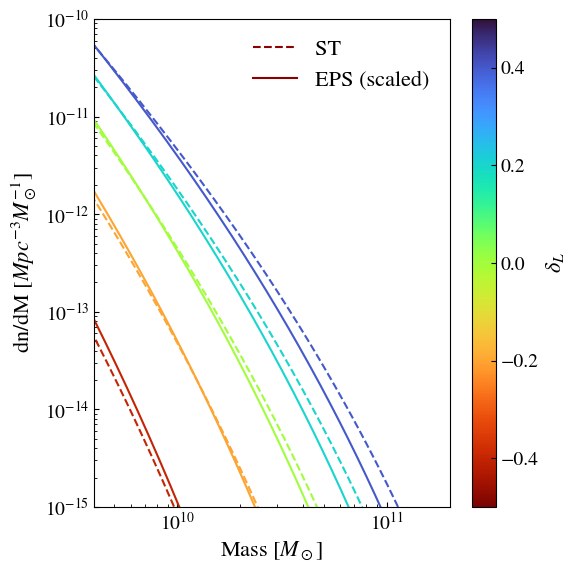

In [148]:
plt.figure(figsize=(6, 6))

cmap = cm.turbo_r
norm = plt.Normalize(vmin=-0.5, vmax=0.5)
colors = cmap(norm((delta_range)))

for idx, delta_vary in enumerate(delta_range):
    #reuse the previously done computation stored in kh_results and pk_results
    # plt.loglog(M_list2*h, np.array(n_EPS_results[idx])/h**4, '-', color=colors[idx])
    plt.loglog(M_list2*h, np.array(n_EPS_scaled_results[idx])/h**4, '-', color=colors[idx])
    plt.loglog(M_list2*h, np.array(n_cST_results[idx])/h**4, '--', color=colors[idx])
plt.loglog([], [], '--', label='ST', color='darkred')
plt.loglog([], [], '-', label='EPS (scaled)', color='darkred')
# plt.loglog(M_list2*h, np.array(n_PS_hirrah)/h**4, 'k-', label = "PS HMF")

# plt.loglog(M_list2*h, np.array(n_ST_hirrah)/h**4, 'k--', label = "ST HMF")

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('$\delta_L$')

# plt.title(f"CMF - $R_0$={R0_mpc} Mpc - z={z_hirrah21} (HIRRAH21)")
plt.xlim([4e9, 2e11])
plt.ylim([1e-15, 1e-10])
plt.xlabel('Mass [$M_\odot$]')
plt.ylabel('dn/dM $[Mpc^{-3}M_\odot^{-1}]$')
plt.tight_layout()
plt.legend(fontsize=16)
plt.savefig('./saved_results/misc/my_cmf_z948_reprod_meriot.svg', dpi=300, bbox_inches='tight')
plt.show()

Once more, there are much more low-mass halos than higher mass halos.

Additionally, and as anticipated, the more a region is dense, the easiest it is for structure to gravitationally collapse onto themselves.

# Fraction of collapsed mass

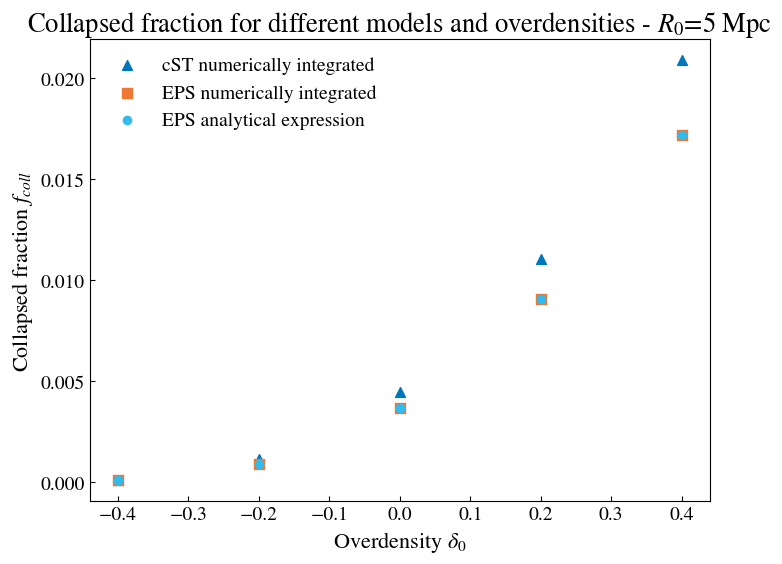

In [149]:
plt.figure(figsize=(8, 6))

plt.scatter(delta_range, fcoll_cST_results, label="cST numerically integrated", marker="^", alpha=1, s=50) 
plt.scatter(delta_range, fcoll_EPS_results, label="EPS numerically integrated", marker="s", alpha=1, s=50) 
plt.scatter(delta_range, fcoll_EPS_analytical, label="EPS analytical expression", marker="o", alpha=1)  

plt.title(f"Collapsed fraction for different models and overdensities - $R_0$={R0_mpc} Mpc")
plt.xlabel('Overdensity $\delta_0$')
plt.ylabel('Collapsed fraction $f_{coll}$')
plt.legend()
plt.show()

On this last graph we can see that the numerical and analystical EPS formalisms are the same, we are therefore confident that the cST numerically integrated data is correct